# 5.1 - Generalization

* [5.1.1 - Underfitting and Overfitting](#first-bullet)
* [5.1.2 - Generalization in Deep Learning](#second-bullet)

## 5.1.1 - Underfitting and Overfitting <a class="anchor" id="first-bullet"></a>

Our goal should always be to create a model that generalizes to data never seen before by the neural netowrk.  We are likely overfitting our model if we see an increase in our training accuracy and decrease in our training loss function, but an increase in our validation loss and little to no improvement in our validation accuracy.  

The example below shows that our neural network can fit itself to noisy data that does not have any significant meaning.  The MNIST digits dataset will be used to show this by either adding additional noise to each training example, or additonal pixels that contain no data.

Start by loading the MNIST digits data set.  Although not required and not suggested by the book, we can take a look at the image arrays using matplotlib before we flatten them for training.

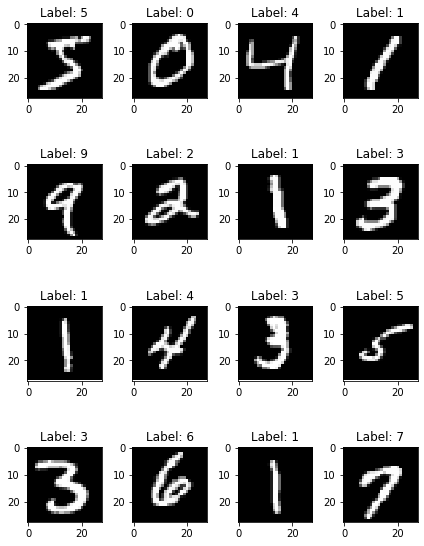

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

(train_images, train_labels), _ = mnist.load_data()

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_labels[i]))
plt.tight_layout()
plt.show()

Now reshape the data and add another feature of either noise or blank cells to our original data set.  The author was not clear, but we are adding another feature to each image when concatenating our synthetic data, not creating new training examples.  The idea is that we have two images per label, one with useful (the original) data, and one image that means nothing.

The final shape of each data set is (60000, 1568), representing 60000 training examples with the first 784 pixels containing actual data, and the last 784 pixels containing junk.

In [2]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

train_images_with_noise_channels = np.concatenate(
  [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

print(np.shape(train_images_with_noise_channels))
print(np.shape(train_images_with_zeros_channels))

(60000, 1568)
(60000, 1568)


For example, let's examine the training images with zero channels.  There's nothing really unusual about the data, but the entire lower half of the image could safely be removed and not cause any loss of information.

The images with noise follows the same theme, with the exception that the bottom half of the image is static instead of blank.

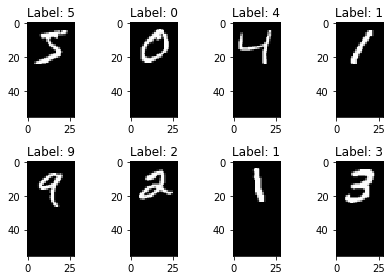

In [3]:
zero_images = train_images_with_zeros_channels.reshape((60000, 56, 28))

num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(zero_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_labels[i]))
plt.tight_layout()
plt.show()

Define our model and train on our training images with noise and training images with blank images data sets.

In [4]:
def get_model():
  model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = get_model()
hist_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
hist_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 5s 14ms/step - loss: 0.6278 - accuracy: 0.8121 - val_loss: 0.3437 - val_accuracy: 0.8888
Epoch 2/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2439 - accuracy: 0.9246 - val_loss: 0.2432 - val_accuracy: 0.9249
Epoch 3/10
375/375 [==============================] - 6s 15ms/step - loss: 0.1596 - accuracy: 0.9508 - val_loss: 0.1547 - val_accuracy: 0.9534
Epoch 4/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1120 - accuracy: 0.9658 - val_loss: 0.1332 - val_accuracy: 0.9617
Epoch 5/10
375/375 [==============================] - 5s 14ms/step - loss: 0.0811 - accuracy: 0.9745 - val_loss: 0.2136 - val_accuracy: 0.9393
Epoch 6/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0616 - accuracy: 0.9801 - val_loss: 0.1135 - val_accuracy: 0.9675
Epoch 7/10
375/375 [==============================] - 6s 15ms/step - loss: 0.0446 - accuracy: 0.9855 - val_loss: 0.1227 - val_accuracy: 0.9671

Now plot out accuracies for each model.

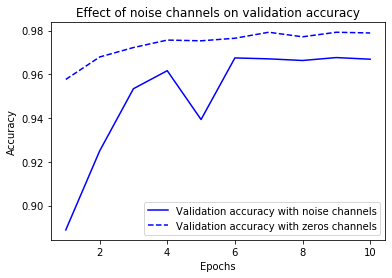

In [5]:
val_acc_noise = hist_noise.history['val_accuracy']
val_acc_zeros = hist_zeros.history['val_accuracy']
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, 'b-',
         label='Validation accuracy with noise channels')
plt.plot(epochs, val_acc_zeros, 'b--',
         label='Validation accuracy with zeros channels')
plt.title('Effect of noise channels on validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Overall both models performed well, but training set with blank images performed better than our data containing noise.  The idea behind this is that neural networks will sometimes try to fit the network to meaningless noise that seems important to the training data, but does not generalize to the validation data.

## 5.1.2 - Generalization in Deep Learning <a class="anchor" id="second-bullet"></a>

We can fit our model to just about any data and see an improvement in training accuracy and training loss over each epoch.  Unfortunately, all we are really doing is memorizing the training data; the model has no real application to data never seen before by the network.

To show this, we will shuffle the labels around on our training data and show that we can fit the model, but our model is essentially meaningless.

In [6]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
  layers.Dense(512, activation='relu'),
  layers.Dense(10, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 3s 8ms/step - loss: 2.3175 - accuracy: 0.1051 - val_loss: 2.3079 - val_accuracy: 0.1066
Epoch 2/100
375/375 [==============================] - 3s 7ms/step - loss: 2.3003 - accuracy: 0.1153 - val_loss: 2.3095 - val_accuracy: 0.1096
Epoch 3/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2914 - accuracy: 0.1252 - val_loss: 2.3148 - val_accuracy: 0.1013
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 2.2775 - accuracy: 0.1395 - val_loss: 2.3224 - val_accuracy: 0.1079
Epoch 5/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2607 - accuracy: 0.1518 - val_loss: 2.3386 - val_accuracy: 0.1051
Epoch 6/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2393 - accuracy: 0.1675 - val_loss: 2.3439 - val_accuracy: 0.1087
Epoch 7/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2143 - accuracy: 0.1789 - val_loss: 2.3571 - val_accuracy: 0.1047

Our training accuracy is decent given that our training data means nothing.  However, our validation accuracy is about 10%, which is what we might expect if we randomly guessed a value from 0-9.